# Initial Imports

In [ ]:
import random
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
!pip install opencv-python

In [ ]:
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# folder structure
# /Test
#     /images
#.    /masks
# /Train
# /Val

origin_dir = '/content/drive/My Drive/LoveDA_Dataset/origin'

out_dir = '/content/drive/My Drive/LoveDA_Dataset/output'
print(os.listdir(origin_dir))

['Train', 'Test', 'Val']


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# (DON'T TOUCH) Prepare dataset

Convert raw data into 512 x 512, generate .txt

In [ ]:
# cleanup output file before regenerating dataest
if os.path.exists(out_dir) and os.path.isdir(out_dir):
    shutil.rmtree(out_dir)
    print(f"DEBUG: {out_dir} removed.")

os.mkdir(out_dir)
print(f"DEBUG: {out_dir} recreated.")


NameError: ignored

In [ ]:
TARGET_SIZE = 512

In [ ]:
def export_stats(folder_name, stats_data):
    stats_filename = f"{folder_name.lower()}.csv"
    stats_out_path = os.path.join(out_dir, stats_filename)
    stats_df = pd.DataFrame(stats_data)
    stats_df.to_csv(stats_out_path,index=False)
    print(f"DEBUG: status data exported to {stats_out_path}")


def process_single_folder(folder_name):
    folder_path = os.path.join(origin_dir, folder_name)

    img_folder_path = os.path.join(folder_path, "images")
    mask_folder_path = os.path.join(folder_path, "masks")

    img_out_folder_path = os.path.join(out_dir, folder_name, "images")
    mask_out_folder_path = os.path.join(out_dir, folder_name, "masks")

    for fout_path in [img_out_folder_path, mask_out_folder_path]:
        if not os.path.exists(fout_path):
            os.makedirs(fout_path)
            print(f"DEBUG: {fout_path} created.")

    # track all status for each folder
    all_stats = []

    for img_name in os.listdir(img_folder_path):
        if img_name == '.DS_Store':
            continue

        img_path = os.path.join(img_folder_path, img_name)
        mask_path = os.path.join(mask_folder_path, img_name)

        if not os.path.exists(mask_path):
            print(f"ERROR: missing mask file for {folder_name}/images/{img_name}")
            # skip if mask is missing
            continue

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        if img.shape[:2] != mask.shape[:2]:
            print(f"ERROR: mismatched mask file for {folder_name}/images/{img_name}")
            # skip if size doesn't match
            continue

        split_img_idx = 0

        img_id = os.path.splitext(os.path.basename(img_path))[0]
        for y in range(0, img.shape[0], TARGET_SIZE):
            for x in range(0, img.shape[1], TARGET_SIZE):
                new_img = img[y:y + TARGET_SIZE, x:x + TARGET_SIZE]
                new_mask = mask[y:y + TARGET_SIZE, x:x + TARGET_SIZE]

                if new_img.shape[0] == TARGET_SIZE and new_img.shape[1] == TARGET_SIZE:
                    new_filename = f"{img_id}_{split_img_idx}.png"
                    img_out_path = os.path.join(img_out_folder_path, new_filename)
                    cv2.imwrite(img_out_path, new_img)

                    mask_out_path = os.path.join(mask_out_folder_path, new_filename)
                    cv2.imwrite(mask_out_path, new_mask)

                    uniq_classes, class_count = np.unique(new_mask, return_counts=True)

                    all_stats.append({
                        "filename": new_filename,
                        "unique_classes": uniq_classes.tolist(),
                        "class_count": class_count.tolist()
                    })

                split_img_idx += 1

    print(f"DEBUG: Processed {folder_name} folder (generated {len(all_stats)} images)")
    export_stats(folder_name, all_stats)

In [ ]:
folder_list = ['Train', 'Test', 'Val']

for folder_name in folder_list:
    process_single_folder(folder_name)

NameError: ignored

# Dataset Loader

In [ ]:
from enum import Enum

class LABEL_MAP(Enum):
    NODATA=0
    Background=1
    Building=2
    Road=3
    Water=4
    Barren=5
    Forest=6
    Agricultural=7


In [ ]:
# Generate class weights from training set

def str_to_list(s):
    if s.startswith('[') and s.endswith(']'):
        s = s[1:-1]  # Remove square brackets
        s = [int(item) for item in s.split(',')]  # Assuming integers in the list
        return s
    else:
        return []

def get_class_weights(folder_name, exclude_nodata = True):
    stats_filename = f"{out_dir}/{folder_name.lower()}.csv"
    stats_df = pd.read_csv(stats_filename, converters={'unique_classes': str_to_list, 'class_count': str_to_list})
    cols = ['unique_classes', 'class_count']
    stats_df = stats_df[cols].explode(cols)

    for col in cols:
        stats_df[col] = stats_df[col].astype(int)

    if exclude_nodata:
        nodata_mask = (stats_df['unique_classes'] == LABEL_MAP.NODATA.value)
        stats_df.loc[nodata_mask, 'class_count'] = 0

    grouped = stats_df.groupby('unique_classes')['class_count'].sum().reset_index()
    total_sum = grouped['class_count'].sum()

    grouped['weights'] = grouped['class_count'] / total_sum


    weights_dict = dict(zip(grouped['unique_classes'], grouped['weights']))

    return weights_dict



In [ ]:
train_class_weights = get_class_weights('Train')

print(train_class_weights)

{0: 0.0, 1: 0.44035941805539147, 2: 0.18859757981569503, 3: 0.08689714597002755, 4: 0.054022178089893624, 5: 0.0757832467603697, 6: 0.08758123146981778, 7: 0.06675919983880484}


In [ ]:
num_cpu_cores = os.cpu_count()
print(f"Number of CPU cores: {num_cpu_cores}")
num_workers = num_cpu_cores - 1

Number of CPU cores: 8


In [ ]:
class LoveDA(Dataset):
    def __init__(self, data_dir, stats_file, image_transform=None, mask_transform = None):
        self.data_dir = data_dir

        self.image_transform = image_transform
        self.mask_transform = mask_transform

        self.image_folder = os.path.join(data_dir, 'images')
        self.mask_folder = os.path.join(data_dir, 'masks')

        stats_df = pd.read_csv(stats_file)
        self.filenames = stats_df['filename'].to_list()

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_filename = self.filenames[idx]
        img_name = os.path.join(self.data_dir, 'images', img_filename)
        mask_name = os.path.join(self.data_dir,'masks', img_filename)

        image = Image.open(img_name)

        if self.image_transform:
            image = self.image_transform(image)

        mask = cv2.imread(mask_name) # in numpy.ndarray (512, 512, 3)
        mask = torch.from_numpy(np.transpose(mask, (2, 0, 1)))
        # collapse duplicated labels
        mask = mask[0, :, :]
        return image, mask

img_transform = transforms.Compose([
    transforms.ToTensor(),
    # Add other transforms as needed (e.g., data augmentation)
])


train_dataset = LoveDA(data_dir=f"{out_dir}/Train", stats_file=f"{out_dir}/train.csv", image_transform=img_transform)
val_dataset = LoveDA(data_dir=f"{out_dir}/Val", stats_file=f"{out_dir}/val.csv", image_transform=img_transform)
test_dataset = LoveDA(data_dir=f"{out_dir}/Test", stats_file=f"{out_dir}/test.csv", image_transform=img_transform)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)

In [ ]:
train_iter = iter(train_loader)
images, masks = next(train_iter)


print(masks[0])


tensor([[1, 1, 1,  ..., 5, 5, 5],
        [1, 1, 1,  ..., 5, 5, 5],
        [1, 1, 1,  ..., 5, 5, 5],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.uint8)


In [ ]:
def show_random_image_mask(dataset, num_samples=4):
    plt.figure(figsize=(12, 3 * num_samples))

    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)
        image, mask = dataset[idx]

        # Convert PyTorch tensors to NumPy arrays
        image = image.permute(1, 2, 0).cpu().numpy()
        mask = (mask * 32).cpu().numpy()

        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis('off')

        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Mask")
        plt.axis('off')

    plt.show()

-------Train set-------


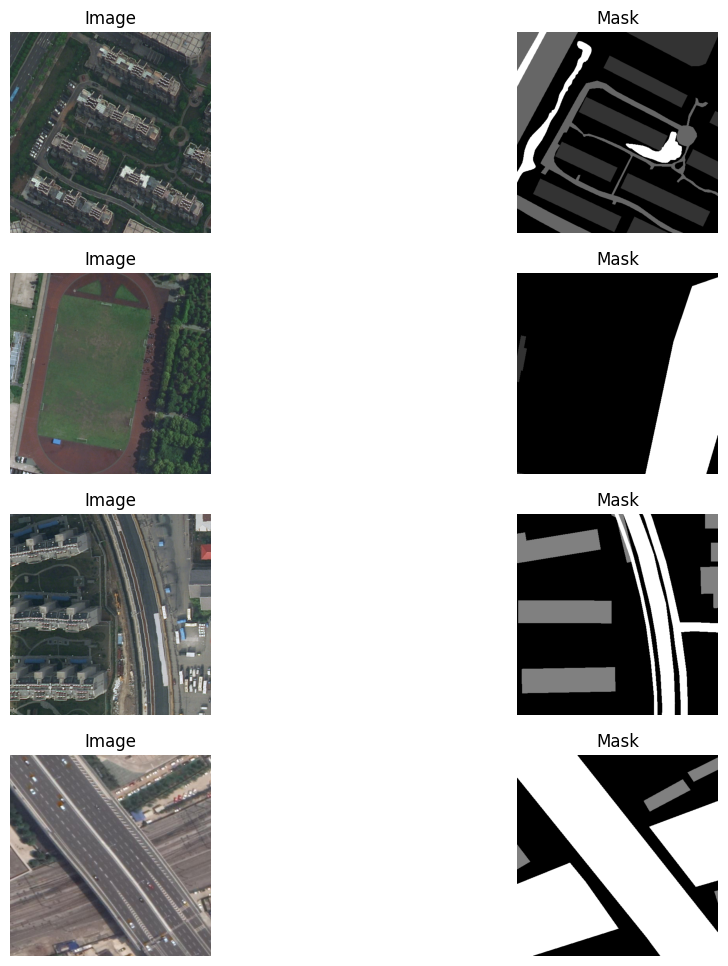

-------Val set-------


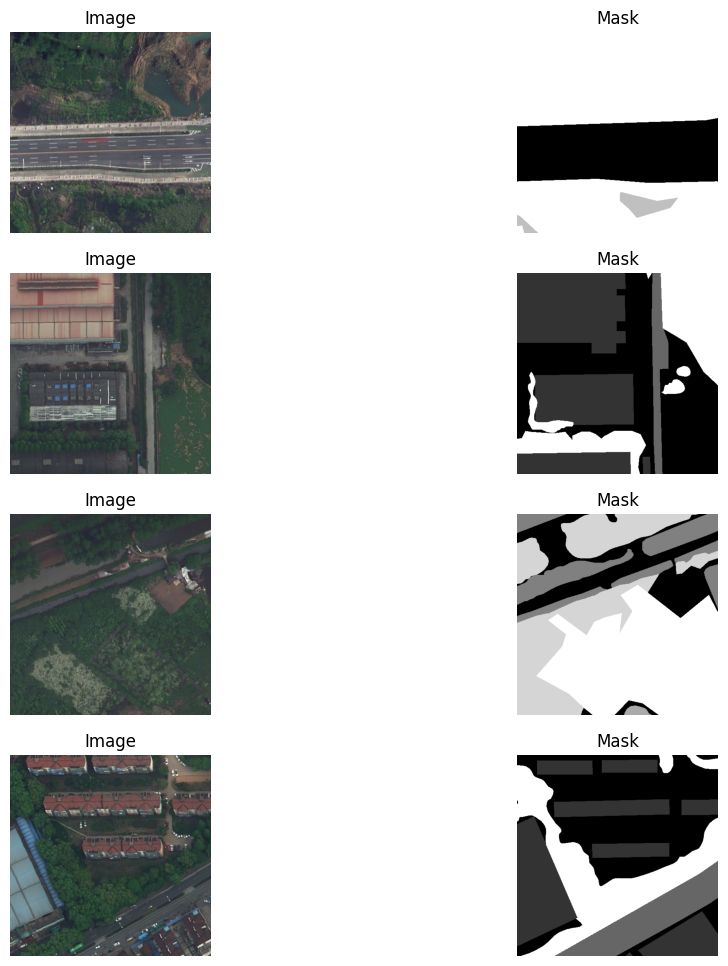

-------Test set-------


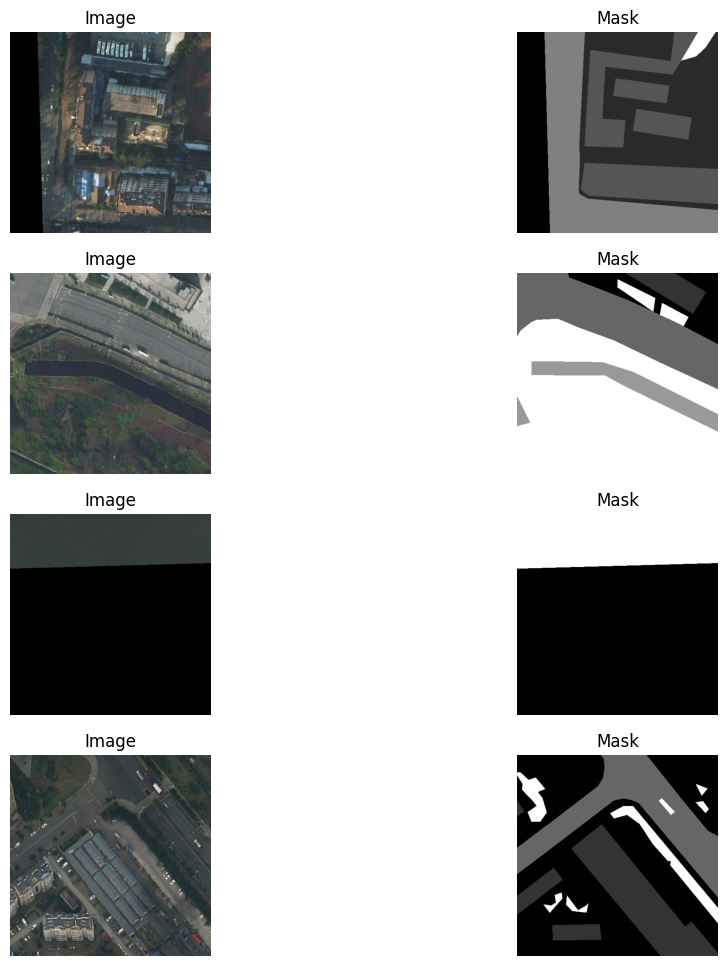

In [ ]:
print("-------Train set-------")
show_random_image_mask(train_dataset, num_samples=4)
print("-------Val set-------")
show_random_image_mask(val_dataset, num_samples=4)
print("-------Test set-------")
show_random_image_mask(test_dataset, num_samples=4)

# Construct UNet


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define classes to help implement UNet

# Conv block is involved in each decoder / encoder
class conv_block(nn.Module):

    def __init__(self, in_c, out_c):
      super().__init__()
      self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
      self.bn1 = nn.BatchNorm2d(out_c)
      self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
      self.bn2 = nn.BatchNorm2d(out_c)
      self.relu = nn.ReLU()

    def forward(self, inputs):
      x = self.conv1(inputs)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.conv2(x)
      x = self.bn2(x)
      x = self.relu(x)
      return x

class encoder_block(nn.Module):

    def __init__(self, in_c, out_c):
      super().__init__()
      self.conv = conv_block(in_c, out_c)
      self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
      x = self.conv(inputs)
      p = self.pool(x)
      return x, p

class decoder_block(nn.Module):

    def __init__(self, in_c, out_c):
      super().__init__()
      self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
      self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
      x = self.up(inputs)
      x = torch.cat([x, skip], axis=1)
      x = self.conv(x)
      return x

class build_unet(nn.Module):

    def __init__(self, num_class):
      super().__init__()
      # """ Encoder """
      self.e1 = encoder_block(3, 64)
      self.e2 = encoder_block(64, 128)
      self.e3 = encoder_block(128, 256)
      self.e4 = encoder_block(256, 512)
      # """ Bottleneck """
      self.b = conv_block(512, 1024)
      # """ Decoder """
      self.d1 = decoder_block(1024, 512)
      self.d2 = decoder_block(512, 256)
      self.d3 = decoder_block(256, 128)
      self.d4 = decoder_block(128, 64)
      #  """ Classifier """
      self.outputs = nn.Conv2d(64, num_class, kernel_size=1, padding=0) #class size length

    def forward(self, inputs):
      # """ Encoder """
      s1, p1 = self.e1(inputs)
      s2, p2 = self.e2(p1)
      s3, p3 = self.e3(p2)
      s4, p4 = self.e4(p3)
      #  """ Bottleneck """
      b = self.b(p4)
      #  """ Decoder """
      d1 = self.d1(b, s4)
      d2 = self.d2(d1, s3)
      d3 = self.d3(d2, s2)
      d4 = self.d4(d3, s1)
      #  """ Classifier """
      outputs = self.outputs(d4)

      # normalized_outputs = torch.sigmoid(outputs)
      return outputs
      # return normalized_outputs

In [ ]:
# Confirm model output is correct
model = build_unet(num_class=8)

image, mask = train_dataset[0]
y = model(image.unsqueeze(0).float())
print(y.shape)
print(y[0])

torch.Size([1, 8, 512, 512])
tensor([[[-0.2466, -0.1474, -0.4952,  ..., -0.0665,  0.1791, -0.3916],
         [-0.0945, -0.2495,  0.0152,  ...,  0.1637,  0.0443,  0.1388],
         [ 0.3093, -0.0059,  0.3797,  ...,  0.3113,  0.8727, -0.3874],
         ...,
         [-0.1643, -0.0484,  0.4361,  ...,  0.0485,  0.2829, -0.2288],
         [ 0.2539,  0.0648,  0.2007,  ..., -0.1247, -0.0967, -0.0386],
         [ 0.1888,  0.2378,  0.1614,  ...,  0.0883,  0.2010, -0.3408]],

        [[ 0.0779, -0.0718,  0.0081,  ..., -0.5440, -0.2866, -0.4999],
         [-0.2568,  0.0290,  0.0780,  ...,  0.5787,  0.3866,  0.0022],
         [-0.1661, -0.5406, -0.5749,  ..., -0.1057, -0.6696,  0.0943],
         ...,
         [-0.0218, -0.1093, -0.2870,  ...,  0.0522, -0.6232,  0.1669],
         [-0.0866, -0.2842, -0.5122,  ..., -0.4722, -0.6771, -0.0326],
         [ 0.0720, -0.0889, -0.0609,  ..., -0.2979,  0.1300, -0.1130]],

        [[ 0.4056,  0.2389,  0.1883,  ...,  0.1459, -0.0909, -0.0915],
         [-0.271

In [ ]:
totalparam = 0
for name, param in model.named_parameters():
  print(name, param.size())
  print("number of parameters at this level: ", param.numel(), '\n')
  totalparam += param.numel()

print("total number of parameters in the model: ", totalparam)

e1.conv.conv1.weight torch.Size([64, 3, 3, 3])
number of parameters at this level:  1728 

e1.conv.conv1.bias torch.Size([64])
number of parameters at this level:  64 

e1.conv.bn1.weight torch.Size([64])
number of parameters at this level:  64 

e1.conv.bn1.bias torch.Size([64])
number of parameters at this level:  64 

e1.conv.conv2.weight torch.Size([64, 64, 3, 3])
number of parameters at this level:  36864 

e1.conv.conv2.bias torch.Size([64])
number of parameters at this level:  64 

e1.conv.bn2.weight torch.Size([64])
number of parameters at this level:  64 

e1.conv.bn2.bias torch.Size([64])
number of parameters at this level:  64 

e2.conv.conv1.weight torch.Size([128, 64, 3, 3])
number of parameters at this level:  73728 

e2.conv.conv1.bias torch.Size([128])
number of parameters at this level:  128 

e2.conv.bn1.weight torch.Size([128])
number of parameters at this level:  128 

e2.conv.bn1.bias torch.Size([128])
number of parameters at this level:  128 

e2.conv.conv2.weight

# Loss Function

In [ ]:
# Define own diceloss to incorporate weights
def weighted_dice_loss(y_true, y_pred, weights):
    """
    Calculate weighted Dice Loss for multiple classes.

    Args:
        y_true: Ground truth label tensor with shape (batch_size, num_classes, height, width)
        y_pred: Predicted probability tensor with shape (batch_size, num_classes, height, width)
        weights: List of weights for each class (length equals num_classes)

    Returns:
        Weighted Dice Loss
    """
    epsilon = 1e-5  # Small constant to prevent division by zero

    intersection = torch.sum(y_true * y_pred, dim=(2, 3))
    union = torch.sum(y_true, dim=(2, 3)) + torch.sum(y_pred, dim=(2, 3))

    dice_scores = (2.0 * intersection + epsilon) / (union + epsilon)

    class_loss = -torch.log(dice_scores)  # Negative log for Dice Loss

    weighted_loss = class_loss * weights
    mean_loss = torch.mean(weighted_loss)

    return mean_loss

In [ ]:
class CustomCrossEntropyLoss(nn.Module):
    def __init__(self, scale_factor=1, weight=None):
        super(CustomCrossEntropyLoss, self).__init__()
        self.scale_factor = scale_factor
        self.weight = weight

    def forward(self, preds, targets):
        # preds: (batch_size, num_class, H, W)
        # targets: (batch_size, H, W)

        valid_mask = (targets != LABEL_MAP.NODATA.value).int()

        filtered_preds = preds.permute(0, 2, 3, 1).contiguous().view(-1, preds.size(1))
        filtered_preds = filtered_preds * valid_mask.view(-1, 1)

        filtered_targets = targets.view(-1)
        filtered_targets = filtered_targets * valid_mask.view(-1)

        num_pixels = torch.sum(valid_mask)

        criterion = nn.CrossEntropyLoss(weight=self.weight)
        loss = criterion(filtered_preds, filtered_targets.long())

        return self.scale_factor * (loss / num_pixels)



In [ ]:
class CustomDiceLoss(nn.Module):
    def __init__(self, num_classes, smooth=1):
        super(CustomDiceLoss, self).__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = nn.functional.softmax(preds, dim=1)

        dice_losses = []
        # ignore nodata class
        for class_idx in range(1, self.num_classes):
            cur_masks = (masks == class_idx).int()
            cur_preds = preds[:, class_idx]

            dice = self.dice_loss(cur_preds, cur_masks)
            dice_losses.append(dice)

        avg_dice = sum(dice_losses) / (self.num_classes -1)

        return avg_dice

    def dice_loss(self, preds, targets):
        intersection = torch.sum(preds * targets)
        union = torch.sum(preds) + torch.sum(preds)
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)

        return 1.0 - dice



# Train Model

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
!pip install segmentation-models-pytorch


In [ ]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
batch_size = 8
num_classes = 8

# Set up data loaders and transformations
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)

In [ ]:
ref_model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=num_classes,                      # model output channels (number of classes in your dataset)
)

In [ ]:
train_class_weights = torch.tensor(list(get_class_weights("Train").values()), dtype=torch.float).to(device)
train_class_weights

tensor([0.0000, 0.4404, 0.1886, 0.0869, 0.0540, 0.0758, 0.0876, 0.0668],
       device='cuda:0')

In [ ]:
# del model
# gc.collect()
# Define your U-Net model, loss function, optimizer, and move the model to GPU if available
# model = build_unet()
model = ref_model
model.to(device)

scale_factor = 1000000
criterion = CustomCrossEntropyLoss(scale_factor=scale_factor, weight=None)
# criterion = CustomDiceLoss(num_classes=num_classes)

optimizer = optim.SGD(model.parameters(), lr=0.001 , momentum=0.9, weight_decay = 0.0001)

In [ ]:
train_iter = iter(train_loader)

images, masks = next(train_iter)
images, masks = images.to(device), masks.to(device)

preds = model(images)


In [ ]:
loss = criterion(preds, masks)
loss

tensor(0.6411, device='cuda:0', grad_fn=<DivBackward0>)

In [ ]:
len(train_loader)

378

In [ ]:
# Training loop
num_epochs = 8
validation_interval = 1;

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    torch.cuda.empty_cache()
    model.train()
    running_loss = 0.0

    print("Training......")
    for i, (images, masks) in enumerate(train_dataloader, 0):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i>0 and i % 20 == 0:
            print(f"Running Epoch {epoch+1}: Current Loss {loss}")

    avg_train_loss = running_loss / len(train_dataloader)
    print(f"Completed Epoch {epoch + 1}: Train Loss {avg_train_loss}")
    train_losses.append(avg_train_loss)

    # Validation loop
    if (epoch + 1) % validation_interval == 0:  # Validate every 'validation_interval' epochs
        print("Validating......")
        model.eval()
        total_loss = 0.0

        for i, (images, masks) in enumerate(val_dataloader, 0):
            images, masks = images.to(device), masks.to(device)

            with torch.no_grad():
                outputs = model(images)

            loss = criterion(outputs, masks)
            total_loss += loss.item()


        avg_val_loss = total_loss / len(val_dataloader)
        print(f"Validation Loss: {avg_val_loss}")
        val_losses.append(avg_val_loss)

    torch.cuda.empty_cache()

Training......
Running Epoch 1: Current Loss 1.2349334955215454
Running Epoch 1: Current Loss 1.0217913389205933
Running Epoch 1: Current Loss 0.7599980235099792
Running Epoch 1: Current Loss 0.5093467831611633
Running Epoch 1: Current Loss 0.6815499067306519
Running Epoch 1: Current Loss 0.6674408316612244
Running Epoch 1: Current Loss 0.49556398391723633
Running Epoch 1: Current Loss 0.5347021222114563
Running Epoch 1: Current Loss 0.6768941283226013
Completed Epoch 1: Train Loss 0.8746147729732372
Validating......
Validation Loss: 0.5768653786182404
Training......
Running Epoch 2: Current Loss 0.6257631778717041
Running Epoch 2: Current Loss 0.43821898102760315
Running Epoch 2: Current Loss 0.5609829425811768
Running Epoch 2: Current Loss 0.5643889307975769
Running Epoch 2: Current Loss 0.5479704737663269
Running Epoch 2: Current Loss 0.6013970971107483
Running Epoch 2: Current Loss 0.5910760164260864
Running Epoch 2: Current Loss 0.4690607488155365
Running Epoch 2: Current Loss 0.9

# Validate Model Performance

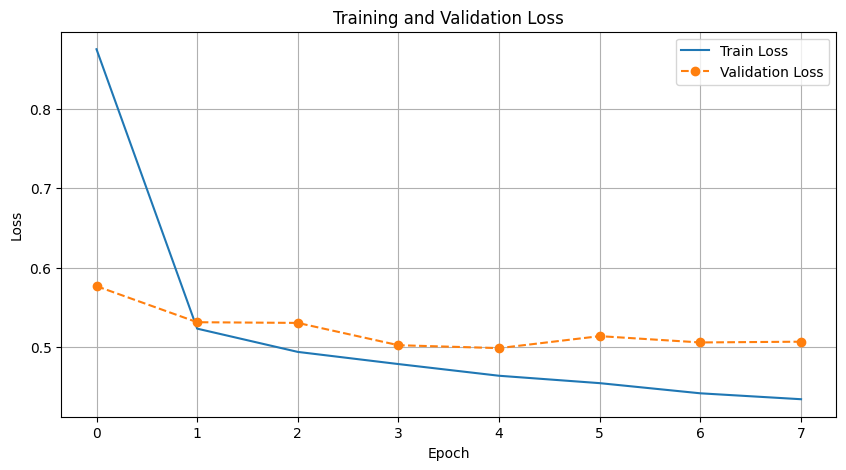

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, len(train_losses)), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(0, len(val_losses)), val_losses, label='Validation Loss', linestyle='--', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def visualize_batch(model, images, masks):
    images, masks = images.to(device), masks.to(device)

    # Forward pass to get predictions
    with torch.no_grad():
        outputs = model(images)

    # Convert predicted masks and expected masks to CPU and numpy arrays
    predicted_masks = outputs.cpu().numpy()
    expected_masks = masks.cpu().numpy()

    # Find the index of the maximum value across all channels for each pixel
    max_predicted_mask_index = np.argmax(predicted_masks, axis=1)
    # print(max_predicted_mask_index[0])

    # Plot the input image, max predicted mask, and expected mask
    for j in range(images.size(0)):  # Loop through the batch

        plt.figure(figsize=(12, 4))

        # Plot the input image
        plt.subplot(1, 3, 1)
        plt.imshow(images[j, 0].cpu().numpy())
        plt.title("Input Image")
        plt.axis('off')

        # Plot the max predicted mask as the index of the highest value
        plt.subplot(1, 3, 2)
        plt.imshow(max_predicted_mask_index[j]*32)  # Use a different colormap for better visualization
        plt.title("Max Predicted Mask Index")
        plt.axis('off')

        # Plot the expected mask
        plt.subplot(1, 3, 3)
        plt.imshow(expected_masks[j]*32)
        plt.title("Expected Mask")
        plt.axis('off')

        plt.show()

In [ ]:
model.eval()
val_iter = iter(val_dataloader)



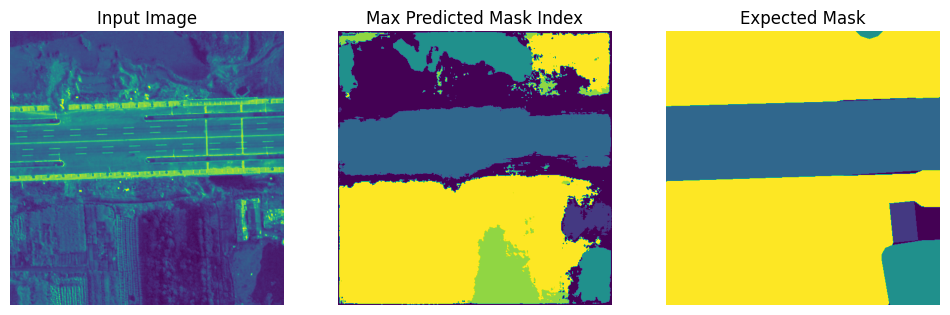

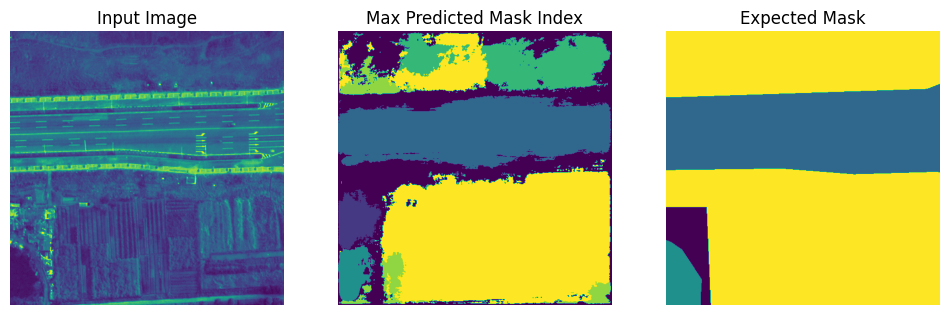

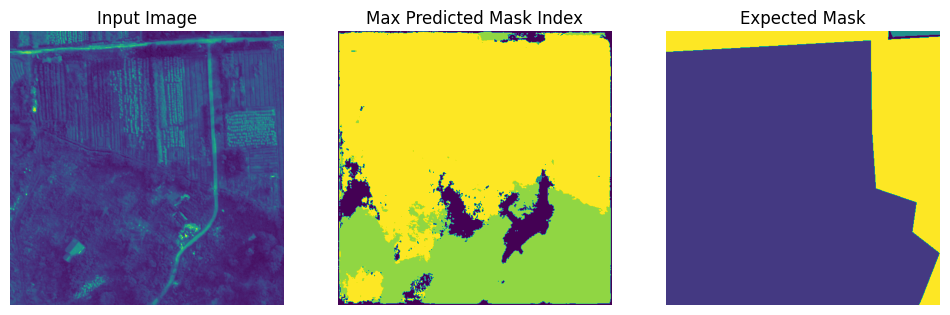

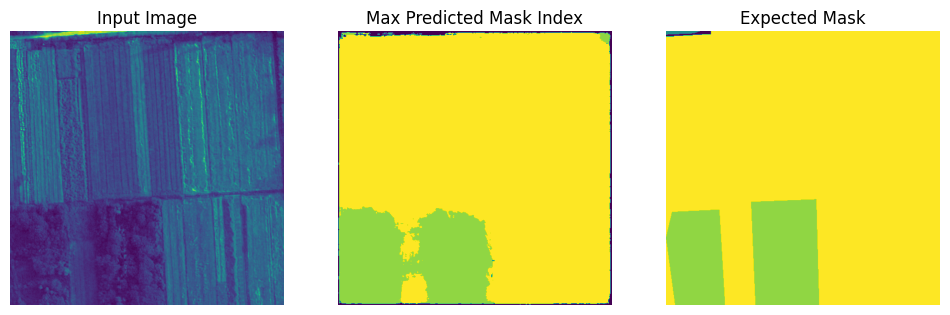

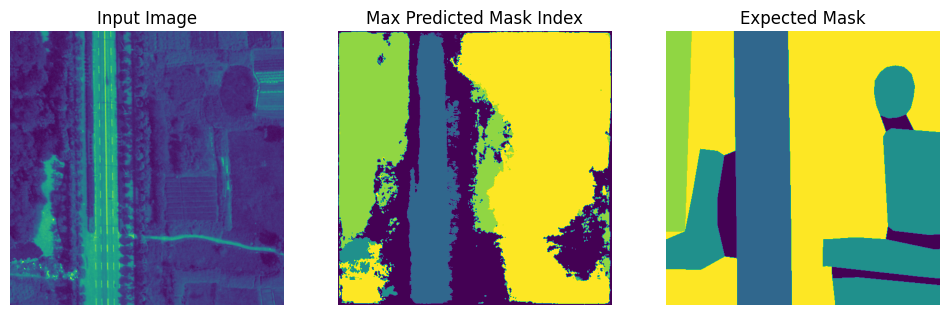

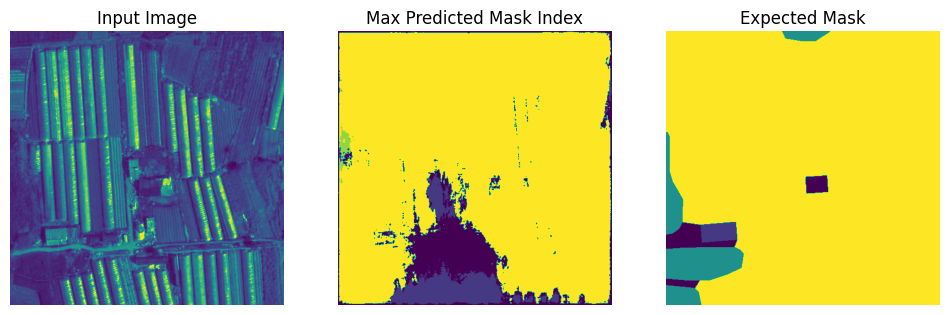

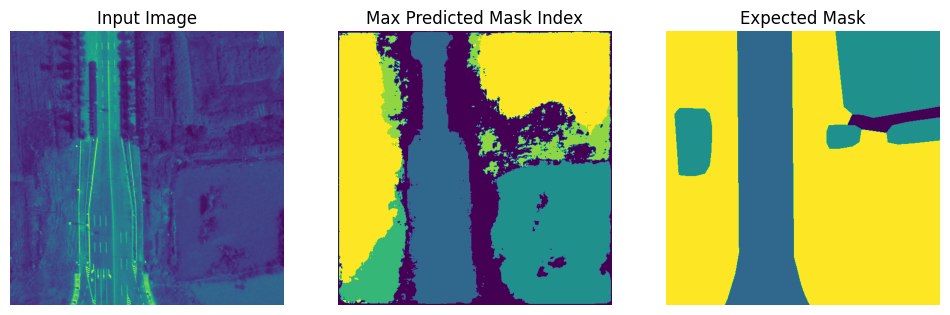

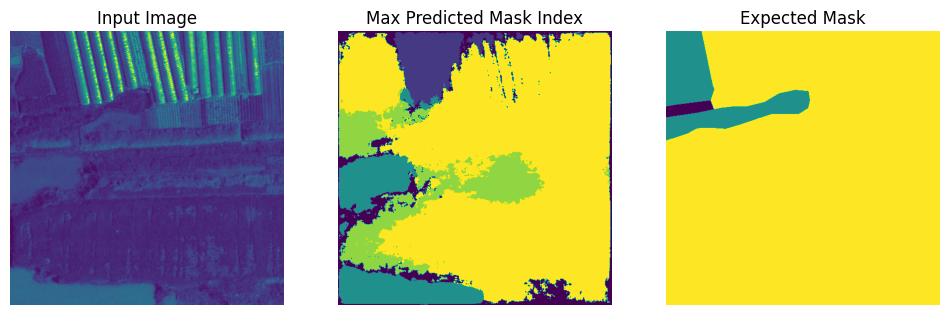

In [ ]:
images, masks = next(val_iter)
visualize_batch(model, images, masks)